In [1]:
import brainsss
import os
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.cluster import AgglomerativeClustering
import scipy
from scipy.cluster.hierarchy import dendrogram
from scipy.cluster.hierarchy import fcluster
from scipy.cluster import hierarchy
import matplotlib as mpl
from matplotlib.pyplot import cm
import random
from scipy.stats import sem
import time
import h5py
import ants
import nibabel as nib
import matplotlib
from scipy.ndimage import gaussian_filter1d

/home/users/yandanw/.local/lib/python3.6/site-packages/ants/viz/render_surface_function.py:16: UserWarning:

Cant import Plotly. Install it `pip install chart_studio` if you want to use ants.render_surface_function



In [2]:
func_path = '/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/20190101_walking_dataset/fly_287/func_0/'

In [6]:
closed_loop_h5_file = os.path.join(func_path, 'visual', '20220806_114038.h5')
f = h5py.File(closed_loop_h5_file, 'r')
start_thetas = f.attrs['start_theta']

OSError: Unable to open file (unable to open file: name = '/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/20190101_walking_dataset/fly_249/func_0/visual/20220806_114038.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

In [4]:
###########################
### PREP VISUAL STIMULI ###
###########################

vision_path = os.path.join(func_path, 'visual')
### Load Photodiode ###
t, ft_triggers, pd1, pd2 = brainsss.load_photodiode(vision_path)
stimulus_start_times = brainsss.extract_stim_times_from_pd(pd2, t)
### Unifrom the units and Make then intigers ###
stimulus_start_times = (stimulus_start_times*100).astype('int') #index needs to be an integers

####################
### Prep Fictrac ###
####################

fictrac_path = os.path.join(func_path, 'fictrac')
fictrac_raw = brainsss.load_fictrac(fictrac_path)

fps = 100
resolution = 10 #desired resolution in ms
expt_len = fictrac_raw.shape[0]/fps*1000
behaviors = ['dRotLabY', 'dRotLabZ', 'heading']
fictrac = {}
for behavior in behaviors:
    if behavior == 'dRotLabY': short = 'Y'
    elif behavior == 'dRotLabZ': short = 'Z'
    elif behavior == 'heading': short = 'h'
    fictrac[short] = brainsss.smooth_and_interp_fictrac(fictrac_raw, fps, resolution, expt_len, behavior)
    #fictrac[short] = np.roll(fictrac[short],400) # <------- misalignment is corrected !!!!!!
fictrac_timestamps = np.arange(0,expt_len,resolution)

fictrac['h'] = np.rad2deg(fictrac['h'])

def extract_traces(fictrac, stim_times, pre_window, post_window, behavior='Z'):
    traces = []
    for i in range(len(stim_times)):
        trace = fictrac[behavior][stim_times[i]-pre_window:stim_times[i]+post_window]
        if len(trace) == pre_window + post_window: # this handles fictrac that crashed or was aborted or some bullshit
            traces.append(trace)
    traces = np.asarray(traces)
    mean_trace = np.mean(traces,axis=0)
    sem_trace = scipy.stats.sem(traces,axis=0)
    return traces, mean_trace, sem_trace

loading photodiode data... done


In [3]:
###########################
### PREP VISUAL STIMULI ###
###########################

# vision_path = os.path.join(func_path, 'visual')
# ### Load Photodiode ###
# t, ft_triggers, pd1, pd2 = brainsss.load_photodiode(vision_path)
# stimulus_start_times = brainsss.extract_stim_times_from_pd(pd2, t)
# ### Unifrom the units and Make then intigers ###
# stimulus_start_times = (stimulus_start_times*1000).astype('int') #index needs to be an integers


# thetas = np.unique(start_thetas)
# theta_categories = {}
# for theta in thetas:
#     idx = np.where(start_thetas==theta)[0]
#     theta_categories[theta] = stimulus_start_times[idx]

loading photodiode data... done


NameError: name 'start_thetas' is not defined

In [3]:
n_clusters = 2000
cluster_dir = os.path.join(func_path, 'clustering')

load_file = os.path.join(cluster_dir, 'cluster_labels.npy')
cluster_labels = np.load(load_file)

load_file = os.path.join(cluster_dir, 'cluster_signals.npy')
all_signals = np.load(load_file)

In [6]:
all_signals.shape

(49, 2000, 3384)

In [4]:
cluster_labels.shape

(49, 32768)

In [7]:
timestamps = brainsss.load_timestamps(os.path.join(func_path, 'imaging'))

Trying to load timestamp data from hdf5 file.
Success.


In [8]:
fixed = brainsss.load_fda_meanbrain()

In [9]:
atlas = brainsss.load_roi_atlas()

In [10]:
explosion_rois = brainsss.load_explosion_groups()
all_rois = brainsss.unnest_roi_groups(explosion_rois)
roi_masks = brainsss.make_single_roi_masks(all_rois, atlas)
roi_contours = brainsss.make_single_roi_contours(roi_masks, atlas)

In [11]:
def supervoxel_to_full_res(brain, cluster_labels):
    n_clusters = brain.shape[1]
    
    reformed_brain = []
    for z in range(49):
        colored_by_betas = np.zeros((256*128))
        for cluster_num in range(n_clusters):
            cluster_indicies = np.where(cluster_labels[z,:]==cluster_num)[0]
            colored_by_betas[cluster_indicies] = brain[z,cluster_num]
        colored_by_betas = colored_by_betas.reshape(256,128)
        reformed_brain.append(colored_by_betas)
    return np.asarray(reformed_brain)

In [13]:
bin_start = -2000; bin_end = 5000; bin_size = 200
neural_bins = np.arange(bin_start,bin_end,bin_size)
baseline_idx = 8 #-400ms

In [ ]:
# np.where(neural_bins==-400)

In [14]:
all_explosions = {}
all_warps = {}
STA_brains = {}
for theta in thetas:
    event_times_list = theta_categories[theta]
    
    t0 = time.time()
    STA_brain = brainsss.make_STA_brain(neural_signals = all_signals,
                                       neural_timestamps = timestamps,
                                       event_times_list = event_times_list,
                                       neural_bins = neural_bins)
    print(F'STA {time.time()-t0}')

    reformed_STA_brain = brainsss.STA_supervoxel_to_full_res(STA_brain, cluster_labels)
    STA_brain = gaussian_filter1d(reformed_STA_brain,sigma=1,axis=1,truncate=1)
    STA_brains[theta] = STA_brain
    STA_brain -= STA_brain[:,baseline_idx,np.newaxis,:,:]
    
    
    t0 = time.time()
    warps = brainsss.warp_STA_brain(STA_brain=STA_brain, fly='fly_223', fixed=fixed, anat_to_mean_type='myr')
    all_warps[theta] = np.asarray(warps)

    print(F'Warps {time.time()-t0}')
    
    explosions = []
    t0 = time.time()
    for tp in range(len(neural_bins)-1):
        input_canvas = np.ones((500,500,3)) #+.5 #.5 for diverging
        data_to_plot = warps[tp][:,:,::-1]
        vmax = 0.5
        explosion_map = brainsss.place_roi_groups_on_canvas(explosion_rois,
                                                            roi_masks,
                                                            roi_contours,
                                                            data_to_plot,
                                                            input_canvas,
                                                            vmax=vmax,
                                                            cmap='seismic',
                                                            diverging=True)#'hot')
        explosions.append(explosion_map)
    print(F'Explosion {time.time()-t0}')
    all_explosions[theta] = explosions

STA 0.6127829551696777
Warps 25.140741109848022
Explosion 62.0757999420166
STA 0.8566336631774902
Warps 25.067580223083496
Explosion 63.131669759750366
STA 0.7782189846038818
Warps 23.621612071990967
Explosion 62.48771810531616
STA 0.8892898559570312
Warps 24.75589418411255
Explosion 62.72759294509888
STA 0.849905252456665
Warps 23.75164031982422
Explosion 62.83649921417236


In [ ]:
thetas

In [ ]:
plt.imshow(all_explosions[50][15][150:,:])

In [ ]:
all_explosions[50].shape

In [ ]:
save_path = os.path.join(func_path,'figs','20220905e')
os.mkdir(save_path)

In [ ]:
for tp in range(len(neural_bins)):
    plt.figure(figsize=(10,5))
    
    plt.subplot(231)
    plt.imshow(all_explosions[-50][tp][150:,:])
    plt.title('Angle: -50')
    plt.axis('off')

    plt.subplot(232)
    plt.imshow(all_explosions[-25][tp][150:,:])
    plt.title('Angle: -25')
    plt.axis('off')

    plt.subplot(233)
    plt.imshow(all_explosions[0][tp][150:,:])
    plt.title('Angle: 0')
    plt.axis('off')

    plt.subplot(234)
    plt.imshow(all_explosions[50][tp][150:,:])
    plt.title('Angle: 50')
    plt.axis('off')

    plt.subplot(235)
    plt.imshow(all_explosions[25][tp][150:,:])
    plt.title('Angle: 25')
    plt.axis('off')

    plt.text(x=800,y=150,s=f'{neural_bins[tp]}ms',fontsize=14)
    
    save_file = os.path.join(save_path,str(tp).zfill(5))
    plt.savefig(save_file,dpi=300,bbox_inches='tight')
    plt.clf()
    plt.close()

# extract roi traces

In [15]:
roi_ids = brainsss.load_roi_hemi_ids()[0]

In [19]:
# all_warps = {}
# all_warps[-50] = np.asarray(warps)

In [16]:
all_warps[50].shape

(34, 314, 146, 91)

In [17]:
roi_ids
#lets take 'left' 25 'MED_R'

{'left': {3: 'LO_R',
  4: 'NO',
  5: 'BU_R',
  6: 'PB',
  7: 'LH_R',
  8: 'LAL_R',
  9: 'SAD',
  10: 'CAN_R',
  11: 'AMMC_R',
  12: 'ICL_R',
  13: 'VES_R',
  14: 'IB_R',
  15: 'ATL_R',
  16: 'CRE_R',
  17: 'MB_PED_R',
  18: 'MB_VL_R',
  19: 'MB_ML_R',
  20: 'FLA_R',
  22: 'LP_R',
  23: 'EB',
  24: 'AL_R',
  25: 'MED_R',
  26: 'FB',
  27: 'SLP_R',
  28: 'SIP_R',
  29: 'SMP_R',
  30: 'AVLP_R',
  31: 'PVLP_R',
  32: 'IVLP_R',
  33: 'PLP_R',
  34: 'AOTU_R',
  35: 'GOR_R',
  36: 'MB_CA_R',
  37: 'SPS_R',
  38: 'IPS_R',
  39: 'SCL_R',
  40: 'EPA_R',
  49: 'GNG',
  50: 'PRW'},
 'right': {4: 'NO',
  6: 'PB',
  9: 'SAD',
  23: 'EB',
  26: 'FB',
  49: 'GNG',
  50: 'PRW',
  53: 'LO_L',
  54: 'BU_L',
  55: 'LH_L',
  56: 'LAL_L',
  57: 'CAN_L',
  58: 'AMMC_L',
  59: 'ICL_L',
  60: 'VES_L',
  61: 'IB_L',
  62: 'ATL_L',
  63: 'CRE_L',
  64: 'MB_PED_L',
  65: 'MB_VL_L',
  66: 'MB_ML_L',
  67: 'FLA_L',
  69: 'LP_L',
  70: 'AL_L',
  71: 'MED_L',
  72: 'SLP_L',
  73: 'SIP_L',
  74: 'SMP_L',
  75: 'AVLP_L

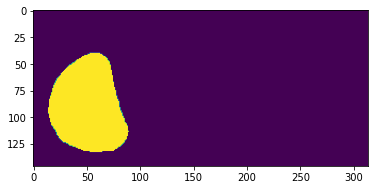

In [18]:
plt.imshow(np.max(roi_masks[25],axis=-1).T)

In [19]:
roi_traces_all = {}
for theta in thetas:
    roi_traces = {}
    for hemi in ['left', 'right']:
        roi_trace = brainsss.extract_roi_signal_traces(roi_ids,
                                                        roi_masks,
                                                        all_warps=all_warps,
                                                        condition=theta,
                                                        hemi=hemi,
                                                        signal_type='mean')
        roi_traces[hemi] = roi_trace
    roi_traces_all[theta] = roi_traces

20.586182117462158
20.46893835067749
20.538419723510742
20.364482641220093
20.49608564376831
20.478468656539917
20.556073665618896
20.412894010543823
20.510365962982178
20.381671905517578


In [20]:
names = list(roi_ids['right'].values())

In [21]:
cmap = matplotlib.cm.get_cmap('RdBu')
plt.figure(figsize=(10,10))
colors = [.1,.25,.5,.75,.9]

<Figure size 720x720 with 0 Axes>

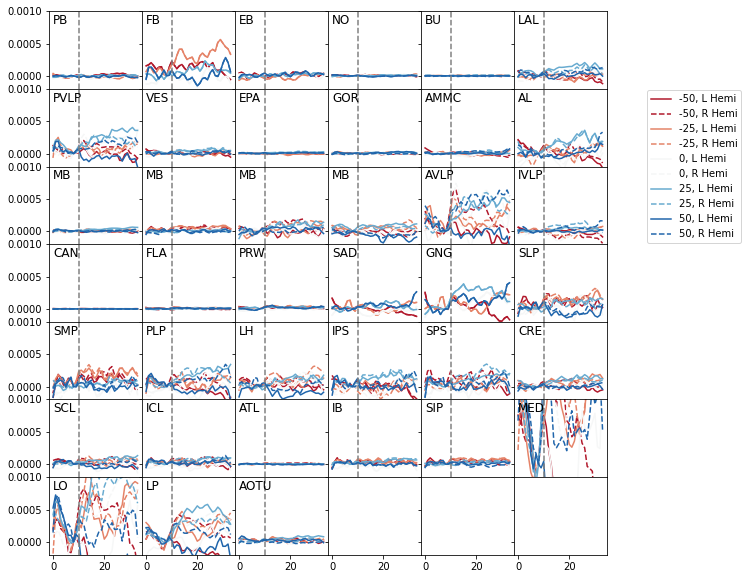

In [22]:
#full_left_group and STA_in_atlas_space_left should indeed both refer to the left brain
#right turn is blue, left turn is red
#solid line is left brain, dashed line is right brain
#so the general hypothesis is for solid lines the red should be higher, and for dashed line the blue should be higher
fig, ax = plt.subplots(7, 6, sharex='col', sharey='row', figsize=(10,10))
pltnum = 0
for i in range(7):
    for j in range(6):
        if pltnum == 39:
            break
        for k,theta in enumerate(thetas):
            ax[i,j].plot(roi_traces_all[theta]['left'][pltnum,:],color=cmap(colors[k]),linestyle='-',label=f'{theta}, L Hemi')
            ax[i,j].plot(roi_traces_all[theta]['right'][pltnum,:],color=cmap(colors[k]),linestyle='--',label=f'{theta}, R Hemi')
        if pltnum == 0:
            ax[i,j].legend(loc='right', bbox_to_anchor=(7.5,-1))
        ax[i,j].text(0, 0.0008, names[pltnum].split('_')[0],fontsize=12)
        ax[i,j].set_ylim(-.0002,.001)
        pltnum += 1
        for line in [10]:
            ax[i,j].axvline(line,linestyle='--',color='grey')
plt.subplots_adjust(hspace=0,wspace=0)

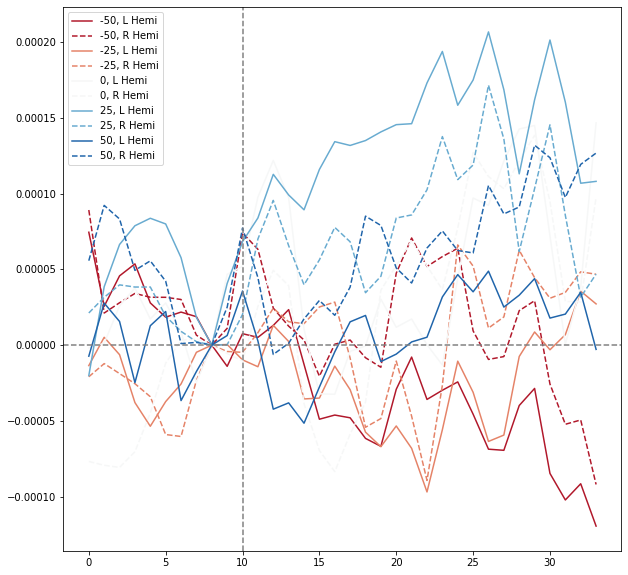

In [23]:
pltnum = np.where(np.asarray(names) == 'LAL_L')[0][0]

plt.figure(figsize=(10,10))
for k,theta in enumerate(thetas):
    plt.plot(roi_traces_all[theta]['left'][pltnum,:],color=cmap(colors[k]),linestyle='-',label=f'{theta}, L Hemi')
    plt.plot(roi_traces_all[theta]['right'][pltnum,:],color=cmap(colors[k]),linestyle='--',label=f'{theta}, R Hemi')

#plt.ylim(-.003,.003)

for line in [10]:
    plt.axvline(line,linestyle='--',color='grey')
plt.axhline(0,linestyle='--',color='grey')
plt.legend()

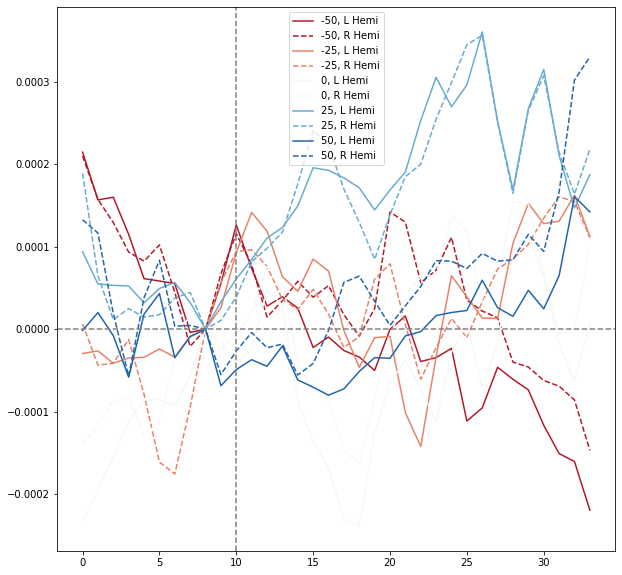

In [24]:
pltnum = np.where(np.asarray(names) == 'AL_L')[0][0]

plt.figure(figsize=(10,10))
for k,theta in enumerate(thetas):
    plt.plot(roi_traces_all[theta]['left'][pltnum,:],color=cmap(colors[k]),linestyle='-',label=f'{theta}, L Hemi')
    plt.plot(roi_traces_all[theta]['right'][pltnum,:],color=cmap(colors[k]),linestyle='--',label=f'{theta}, R Hemi')

#plt.ylim(-.003,.003)

for line in [10]:
    plt.axvline(line,linestyle='--',color='grey')
plt.axhline(0,linestyle='--',color='grey')
plt.legend()

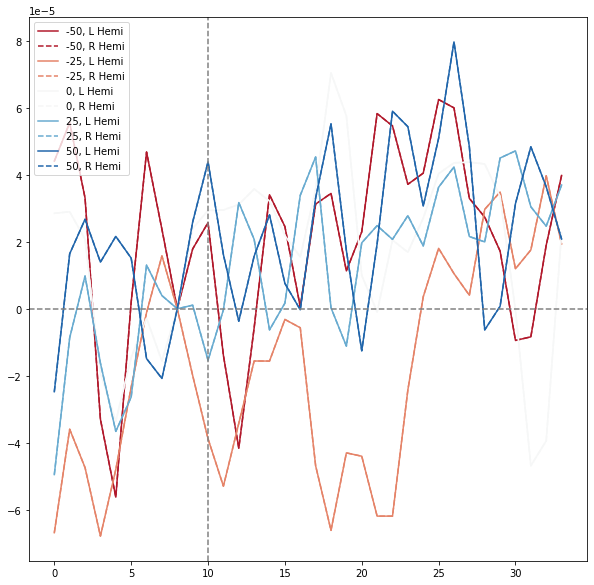

In [25]:
pltnum = np.where(np.asarray(names) == 'EB')[0][0]

plt.figure(figsize=(10,10))
for k,theta in enumerate(thetas):
    plt.plot(roi_traces_all[theta]['left'][pltnum,:],color=cmap(colors[k]),linestyle='-',label=f'{theta}, L Hemi')
    plt.plot(roi_traces_all[theta]['right'][pltnum,:],color=cmap(colors[k]),linestyle='--',label=f'{theta}, R Hemi')

#plt.ylim(-.003,.003)

for line in [10]:
    plt.axvline(line,linestyle='--',color='grey')
plt.axhline(0,linestyle='--',color='grey')
plt.legend()

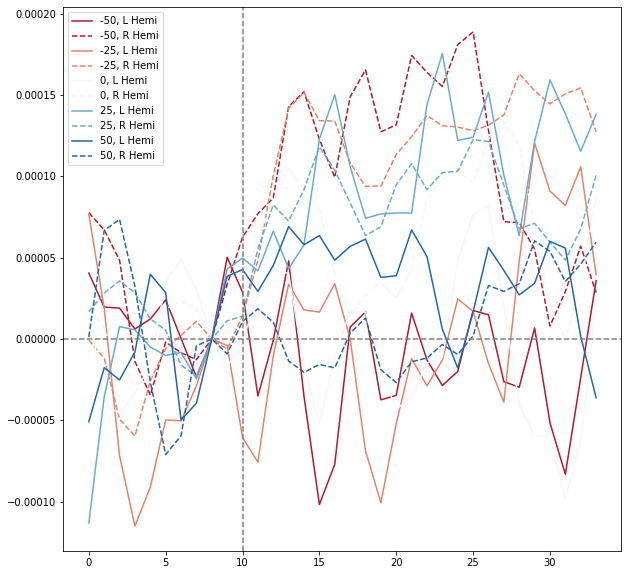

In [26]:
pltnum = np.where(np.asarray(names) == 'MB_ML_L')[0][0]

plt.figure(figsize=(10,10))
for k,theta in enumerate(thetas):
    plt.plot(roi_traces_all[theta]['left'][pltnum,:],color=cmap(colors[k]),linestyle='-',label=f'{theta}, L Hemi')
    plt.plot(roi_traces_all[theta]['right'][pltnum,:],color=cmap(colors[k]),linestyle='--',label=f'{theta}, R Hemi')

#plt.ylim(-.003,.003)

for line in [10]:
    plt.axvline(line,linestyle='--',color='grey')
plt.axhline(0,linestyle='--',color='grey')
plt.legend()

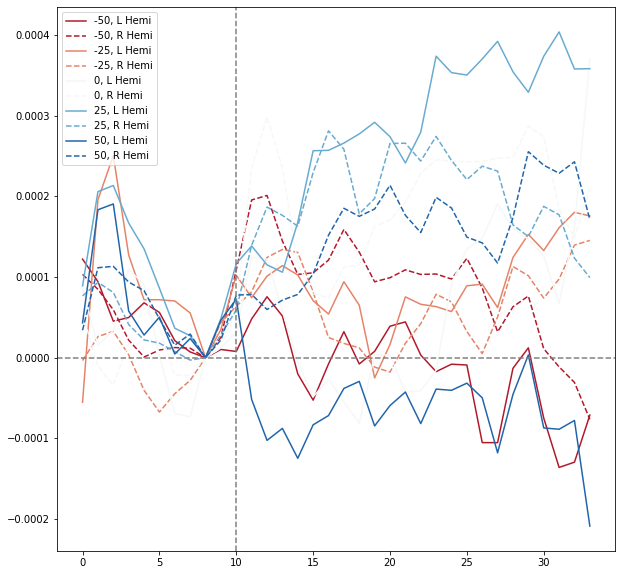

In [27]:
pltnum = np.where(np.asarray(names) == 'PVLP_L')[0][0]

plt.figure(figsize=(10,10))
for k,theta in enumerate(thetas):
    plt.plot(roi_traces_all[theta]['left'][pltnum,:],color=cmap(colors[k]),linestyle='-',label=f'{theta}, L Hemi')
    plt.plot(roi_traces_all[theta]['right'][pltnum,:],color=cmap(colors[k]),linestyle='--',label=f'{theta}, R Hemi')

#plt.ylim(-.003,.003)

for line in [10]:
    plt.axvline(line,linestyle='--',color='grey')
plt.axhline(0,linestyle='--',color='grey')
plt.legend()

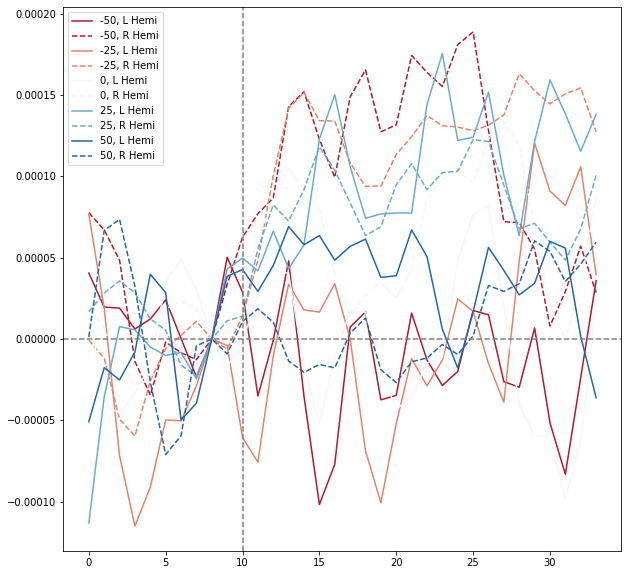

In [28]:
pltnum = np.where(np.asarray(names) == 'MB_ML_L')[0][0]

plt.figure(figsize=(10,10))
for k,theta in enumerate(thetas):
    plt.plot(roi_traces_all[theta]['left'][pltnum,:],color=cmap(colors[k]),linestyle='-',label=f'{theta}, L Hemi')
    plt.plot(roi_traces_all[theta]['right'][pltnum,:],color=cmap(colors[k]),linestyle='--',label=f'{theta}, R Hemi')

#plt.ylim(-.003,.003)

for line in [10]:
    plt.axvline(line,linestyle='--',color='grey')
plt.axhline(0,linestyle='--',color='grey')
plt.legend()

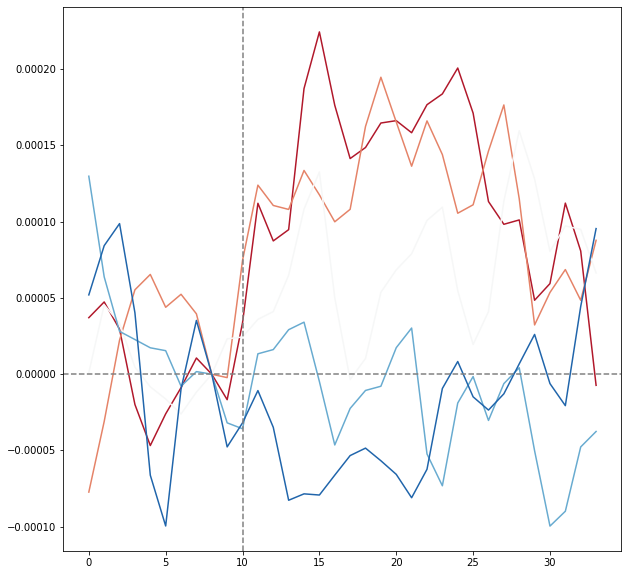

In [29]:
# red is negative theta
# positive y axis means right hemi is higher

pltnum = np.where(np.asarray(names) == 'MB_ML_L')[0][0]

plt.figure(figsize=(10,10))
for k,theta in enumerate(thetas):
    trace = roi_traces_all[theta]['right'][pltnum,:] - roi_traces_all[theta]['left'][pltnum,:]
    plt.plot(trace,color=cmap(colors[k]))


#plt.ylim(-.003,.003)

for line in [10]:
    plt.axvline(line,linestyle='--',color='grey')
plt.axhline(0,linestyle='--',color='grey')

In [30]:
thetas, colors

(array([-50, -25,   0,  25,  50]), [0.1, 0.25, 0.5, 0.75, 0.9])

In [28]:
6: 'PB',
  9: 'SAD',
  23: 'EB',
  26: 'FB',
  49: 'GNG',
  50: 'PRW',
  53: 'LO_L',
  54: 'BU_L',
  55: 'LH_L',
  56: 'LAL_L',
  57: 'CAN_L',
  58: 'AMMC_L',
  59: 'ICL_L',
  60: 'VES_L',
  61: 'IB_L',
  62: 'ATL_L',
  63: 'CRE_L',
  64: 'MB_PED_L',
  65: 'MB_VL_L',
  66: 'MB_ML_L',
  67: 'FLA_L',
  69: 'LP_L',
  70: 'AL_L',
  71: 'MED_L',
  72: 'SLP_L',
  73: 'SIP_L',
  74: 'SMP_L',
  75: 'AVLP_L',
  76: 'PVLP_L',
  77: 'IVLP_L',
  78: 'PLP_L',
  79: 'AOTU_L',
  80: 'GOR_L',
  81: 'MB_CA_L',
  82: 'SPS_L',
  83: 'IPS_L',
  84: 'SCL_L',
  85: 'EPA_L'}}

SyntaxError: invalid syntax (<ipython-input-28-5e80f0fdfbfc>, line 1)

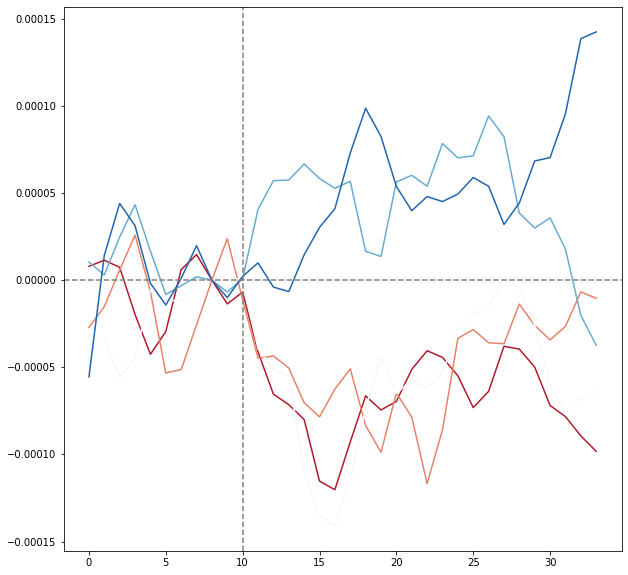

In [31]:
# red is negative theta
# positive y axis means right hemi is higher

pltnum = np.where(np.asarray(names) == 'IVLP_L')[0][0]

plt.figure(figsize=(10,10))
for k,theta in enumerate(thetas):
    trace = roi_traces_all[theta]['right'][pltnum,:] - roi_traces_all[theta]['left'][pltnum,:]
    plt.plot(trace,color=cmap(colors[k]))


#plt.ylim(-.003,.003)

for line in [10]:
    plt.axvline(line,linestyle='--',color='grey')
plt.axhline(0,linestyle='--',color='grey')

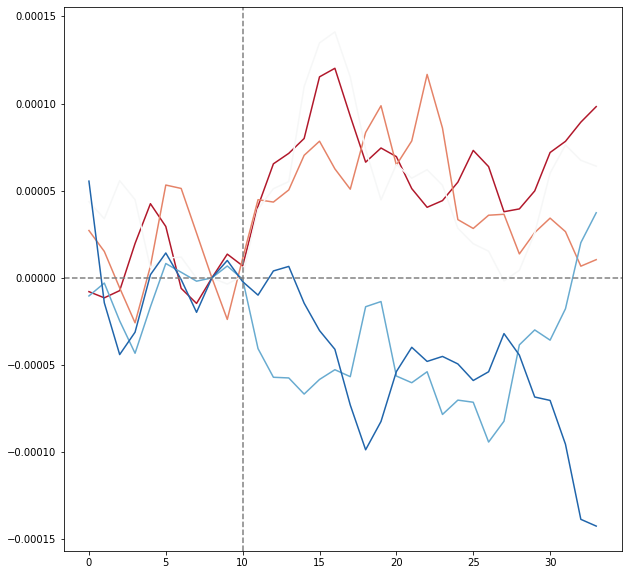

In [32]:
# red is negative theta
# positive y axis means left hemi is higher

pltnum = np.where(np.asarray(names) == 'IVLP_L')[0][0]

plt.figure(figsize=(10,10))
for k,theta in enumerate(thetas):
    trace = roi_traces_all[theta]['left'][pltnum,:] - roi_traces_all[theta]['right'][pltnum,:]
    plt.plot(trace,color=cmap(colors[k]))


#plt.ylim(-.003,.003)

for line in [10]:
    plt.axvline(line,linestyle='--',color='grey')
plt.axhline(0,linestyle='--',color='grey')

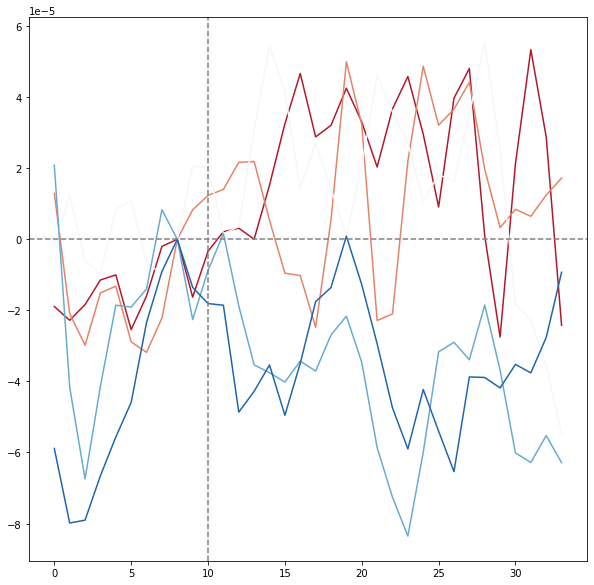

In [33]:
# red is negative theta
# positive y axis means right hemi is higher

pltnum = np.where(np.asarray(names) == 'AOTU_L')[0][0]

plt.figure(figsize=(10,10))
for k,theta in enumerate(thetas):
    trace = roi_traces_all[theta]['right'][pltnum,:] - roi_traces_all[theta]['left'][pltnum,:]
    plt.plot(trace,color=cmap(colors[k]))


#plt.ylim(-.003,.003)

for line in [10]:
    plt.axvline(line,linestyle='--',color='grey')
plt.axhline(0,linestyle='--',color='grey')

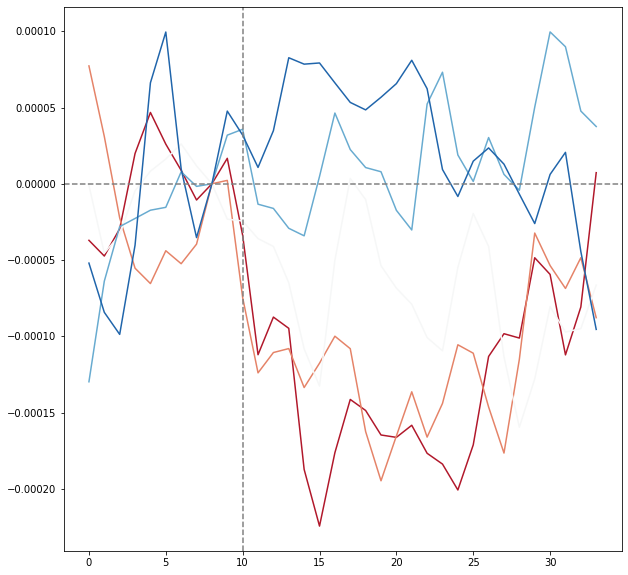

In [34]:
# red is negative theta
# positive y axis means left hemi is higher

pltnum = np.where(np.asarray(names) == 'MB_ML_L')[0][0]

plt.figure(figsize=(10,10))
for k,theta in enumerate(thetas):
    trace = roi_traces_all[theta]['left'][pltnum,:] - roi_traces_all[theta]['right'][pltnum,:]
    plt.plot(trace,color=cmap(colors[k]))


#plt.ylim(-.003,.003)

for line in [10]:
    plt.axvline(line,linestyle='--',color='grey')
plt.axhline(0,linestyle='--',color='grey')

# Look at optic lobes

In [35]:
STA_brain.shape

(49, 34, 256, 128)

In [36]:
file = os.path.join(func_path, 'moco', 'functional_channel_1_moc_mean.nii')
anat = ants.image_read(file)
anat.shape

(256, 128, 49)

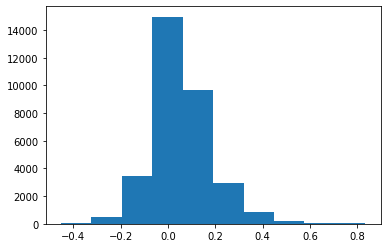

In [46]:
plt.hist(to_plot_25.flatten());

In [47]:
out = np.concatenate((to_plot_25[:,:,np.newaxis],
                      np.zeros(to_plot_25.shape)[:,:,np.newaxis],
                      to_plot_50[:,:,np.newaxis]),axis=2)
out.shape

(128, 256, 3)

In [48]:
img_to_save

NameError: name 'img_to_save' is not defined

In [49]:
anat

ANTsImage (LPI)
	 Pixel Type : float (float32)
	 Components : 1
	 Dimensions : (256, 128, 49)
	 Spacing    : (1.0, 1.0, 1.0)
	 Origin     : (0.0, 0.0, 0.0)
	 Direction  : [-1.  0.  0.  0. -1.  0.  0.  0.  1.]

In [50]:
aff = np.eye(4)

save_file = os.path.join(func_path, 'figs', '20220916_theta25.nii')
brain = STA_brains[25][:,12,:,:]
brain = np.rollaxis(brain,0,3)
img = nib.Nifti1Image(brain, aff)
img.to_filename(save_file)

save_file = os.path.join(func_path, 'figs', '20220916_theta50.nii')
brain = STA_brains[50][:,12,:,:]
brain = np.rollaxis(brain,0,3)
img = nib.Nifti1Image(brain, aff)
img.to_filename(save_file)

save_file = os.path.join(func_path, 'figs', 'anat.nii')
img = nib.Nifti1Image(anat.numpy(), aff)
img.to_filename(save_file)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


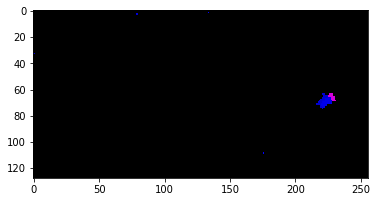

In [51]:
z=17
thresh = .2
plt.imshow(anat[:,:,z].T,cmap='Greys_r')

to_plot_25 = STA_brains[25][z,12,:,:].T
#to_plot[np.where(to_plot<thresh)] = np.nan
#to_plot_25 = to_plot
#plt.imshow(to_plot,cmap='Reds')

to_plot_50 = STA_brains[50][z,12,:,:].T
#to_plot[np.where(to_plot<thresh)] = np.nan
#to_plot_50 = to_plot
#plt.imshow(to_plot,cmap='Blues')

out = np.concatenate((to_plot_25[:,:,np.newaxis],
                      np.zeros(to_plot_25.shape)[:,:,np.newaxis],
                      to_plot_50[:,:,np.newaxis]),axis=2)
out[np.where(out<.8)] = np.nan
plt.imshow(out)

#plt.imshow(STA_brains[25][z,12,:,:].T,vmin=.2,vmax=.5,cmap='Reds',alpha=.5)
#plt.imshow(STA_brains[50][z,12,:,:].T,vmin=.2,vmax=.5,cmap='Blues',alpha=.5)
# #plt.xlim(250,300)
# #plt.ylim(50,90)
# plt.axhline(75,color='k')

In [37]:
save_path = os.path.join(func_path,'figs','20220916a')
EB_mask = roi_masks[23]
for tp in range(len(neural_bins)-1):
    plt.figure(figsize=(10,10))
    for k,theta in enumerate(thetas):
        plt.subplot(1,5,k+1)
        masked_roi = EB_mask*all_warps[theta][tp,:,:,::-1]

        ### maximum projection along z-axis
        # works for negative values
        maxs = np.max(masked_roi,axis=2)
        mins = np.min(masked_roi,axis=2)
        maxs[np.where(np.abs(mins)>maxs)] = mins[np.where(np.abs(mins)>maxs)]

        plt.imshow(maxs.T,cmap='seismic',vmin=-.7,vmax=.7)
        plt.xlim(143,170)
        plt.ylim(70,43)
        plt.title(theta)
        plt.axis('off')
    plt.text(x=90,y=30,s=f'{neural_bins[tp]}ms',fontsize=14)
    save_file = os.path.join(save_path,str(tp).zfill(5))
    plt.savefig(save_file,dpi=300,bbox_inches='tight')
    plt.clf()
    plt.close()

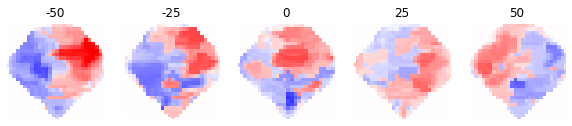

In [38]:
plt.figure(figsize=(10,10))
tp=16
for k,theta in enumerate(thetas):
    plt.subplot(1,5,k+1)
    masked_roi = EB_mask*all_warps[theta][tp,:,:,::-1]

    ### maximum projection along z-axis
    # works for negative values
    maxs = np.max(masked_roi,axis=2)
    mins = np.min(masked_roi,axis=2)
    maxs[np.where(np.abs(mins)>maxs)] = mins[np.where(np.abs(mins)>maxs)]

    plt.imshow(maxs.T,cmap='seismic',vmin=-1,vmax=1)
    plt.xlim(143,170)
    plt.ylim(70,43)
    plt.title(theta)
    plt.axis('off')

In [39]:
170-143, 70-43

(27, 27)

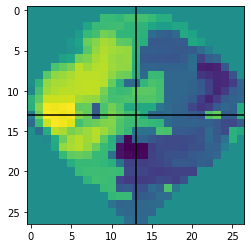

In [40]:
plt.imshow(maxs[144:171,43:70].T)
plt.axvline(13,color='k')
plt.axhline(13,color='k')

In [ ]:
### HW1:  

In [102]:
maxs[144:171,43:70][12][12]

0.14488131807895654

In [108]:
#maxs[144:171,43:70]

In [107]:
#maxs[144:171,43:70] - maxs[144:171,43:70][12][12]

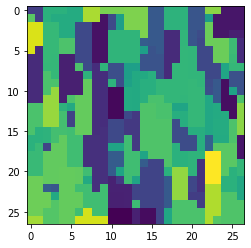

In [110]:
# NORMALIZE TO (0,0)
delta_max = maxs[144:171,43:70].T - maxs[144:171,43:70].T[12][12]
plt.imshow(delta_max.T)

In [ ]:
# make all vectors unit vectors by dividing by length

In [114]:
type(delta_max)

numpy.ndarray

In [41]:
plt.imshow(data)
plt.axhline(10.7)
plt.axvline(8.25)

NameError: name 'data' is not defined

In [401]:
data.shape

(27, 27)

In [409]:
ndimage.measurements.center_of_mass(data)

(-5.967614935296142, -37.40512782008474)

In [407]:
ndimage.measurements.center_of_mass(np.clip(data,0,None))

(10.768054592220016, 8.28565515915927)

In [399]:
from scipy import ndimage

In [45]:
def center_of_mass(array: np.ndarray):
    total = array.sum()
    # alternatively with np.arange as well
    x_coord = (array.sum(axis=1) @ range(array.shape[0])) / total
    y_coord = (array.sum(axis=0) @ range(array.shape[1])) / total
    return x_coord, y_coord


a = np.asarray([[0, 0, 0],
                [0, 4, 4],
                [0, 0, 0]])

b = np.asarray([[0, 1, 2],
                [3, 4, 5]])

print(center_of_mass(data)) # (1.0, 1.5)

(-5.967615626794446, -37.40512821729294)


In [46]:
masses = data
nonZeroMasses = masses[np.nonzero(masses[:,3])] # Not really necessary, can just use masses because 0 mass used as weight will work just fine.
CM = np.average(nonZeroMasses[:,:3], axis=0, weights=nonZeroMasses[:,3])
CM

array([0.00072437, 0.09490502, 0.2111088 ], dtype=float32)

In [47]:
CM = np.average(data, axis=0, weights=data)
np.mean(CM)

0.40621492

In [44]:
data = maxs[144:171,43:70].T

In [65]:
x = 17
y = 14

x0 = x - 13
y0 = y - 13
angle = np.rad2deg(math.atan(y0/x0))
angle

14.036243467926479

In [49]:
### MAKE ANGLES ###

EB = maxs[144:171,43:70]
EB.shape

angles = []
for x in range(27):
    for y in range(27):
        x0 = x - 13
        y0 = y - 13
        try:
            angle = np.arctan2(y0, x0)
        except:
            angle = 0
        angles.append(angle)
angles = np.reshape(angles,(27,27))

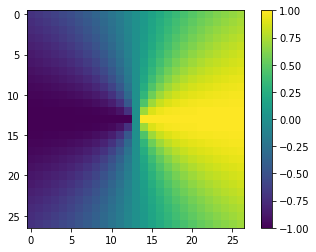

In [66]:
plt.imshow(angles)
plt.colorbar()

In [67]:
bin_start = -np.pi; bin_end = np.pi; bin_size = .5
angle_bins = np.arange(bin_start,bin_end,bin_size)
angle_bins

array([-3.14159265, -2.64159265, -2.14159265, -1.64159265, -1.14159265,
       -0.64159265, -0.14159265,  0.35840735,  0.85840735,  1.35840735,
        1.85840735,  2.35840735,  2.85840735])

In [68]:
out = np.digitize(angles, angle_bins)

In [69]:
bin_nums = np.unique(out)
bin_means = []
for bin_ in bin_nums:
    bin_mean = np.mean(data[np.where((out==bin_)&(data!=0))])
    bin_means.append(bin_mean)

In [70]:
from scipy.stats import circmean

In [71]:
circmean(bin_means)

0.002742730546742678

In [72]:
bin_means

[0.17801912, 0.087572716, -0.04985379, -0.09143952, -0.109989114]

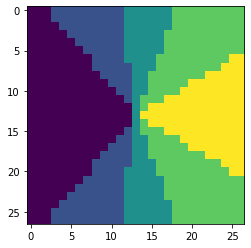

In [73]:
plt.imshow(out)

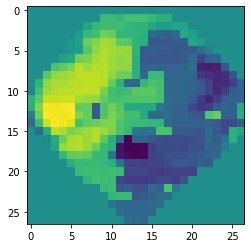

In [74]:
plt.imshow(data)

In [75]:
EB = maxs[144:171,43:70]
EB.shape

angles = []
for x in range(27):
    for y in range(27):
        x0 = x - 13
        y0 = y - 13
        try:
            angle = np.sin(np.arctan2(y0, x0))
        except:
            angle = 0
        angles.append(angle)
angles = np.reshape(angles,(27,27))
#angles = angles+180

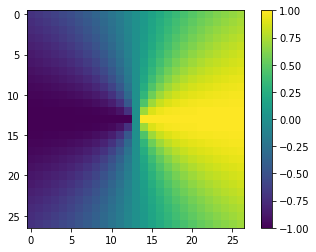

In [76]:
plt.imshow(angles)
plt.colorbar()

In [77]:
import math

In [78]:


np.rad2deg(math.atan(1))

45.0

(60.0, 30.0)

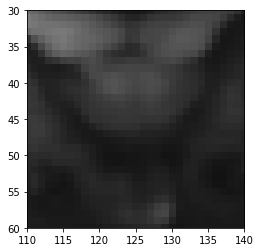

In [79]:
plt.imshow(anat[:,:,28].T,cmap='Greys_r')
plt.xlim(110,140)
plt.ylim(60,30)

In [80]:
maxs.shape

(314, 146)

In [81]:
STA_brains[-25][22:28,13,:,:].shape

(6, 256, 128)

(60.0, 30.0)

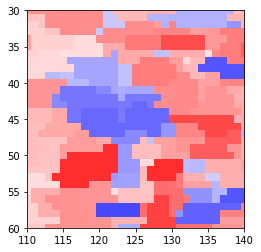

In [82]:
z=25
temp = STA_brains[-25][22:28,13,:,:]

maxs = np.max(temp,axis=0)
mins = np.min(temp,axis=0)
maxs[np.where(np.abs(mins)>maxs)] = mins[np.where(np.abs(mins)>maxs)]


plt.imshow(maxs.T,cmap='seismic',vmin=-1,vmax=1)
plt.xlim(110,140)
plt.ylim(60,30)

In [157]:
out.shape

(128, 256, 3)

In [158]:
out[100,100,:]

array([nan, nan, nan])

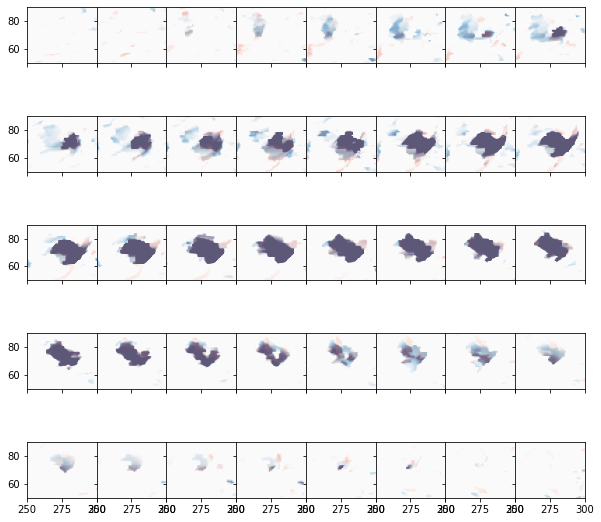

In [124]:
fig, ax = plt.subplots(5, 8, sharex='col', sharey='row', figsize=(10,10))
pltnum = 0
for i in range(5):
    for j in range(8):
        ax[i,j].imshow(all_warps[25][12,:,:,pltnum+10].T,vmin=.2,vmax=.5,cmap='Reds',alpha=.5)
        ax[i,j].imshow(all_warps[50][12,:,:,pltnum+10].T,vmin=.2,vmax=.5,cmap='Blues',alpha=.5)
        ax[i,j].set_xlim(250,300)
        ax[i,j].set_ylim(50,90)
        pltnum+=1
plt.subplots_adjust(hspace=0,wspace=0)

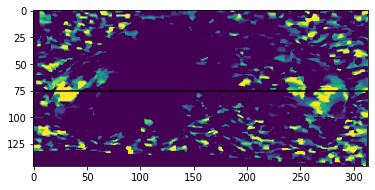

In [104]:
theta = -25
plt.imshow(all_warps[theta][12,:,:,25].T,vmin=.1,vmax=.3)
plt.axhline(75,color='k')

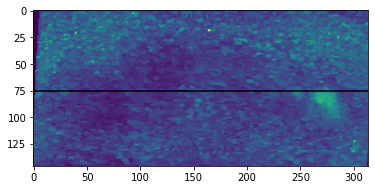

In [74]:
theta = -50
plt.imshow(np.max(all_warps[theta][12,:,:,:],axis=-1).T)
plt.axhline(75,color='k')